In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


✅ Using device: cuda
🎧 Languages Detected: ['.ipynb_checkpoints', 'andhra_pradesh', 'gujarat', 'jharkhand', 'karnataka', 'kerala', 'tamil']


Extracting .ipynb_checkpoints: 0it [00:00, ?it/s]
Extracting tamil: 100%|██████████| 20/20 [00:12<00:00,  1.66it/s]


✅ Saved layer-wise features and labels!

🔹 Evaluating Layer 6...
✅ Layer 6 Accuracy: 95.83%

🔹 Evaluating Layer 9...
✅ Layer 9 Accuracy: 95.83%

🔹 Evaluating Layer 12...
✅ Layer 12 Accuracy: 100.00%


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


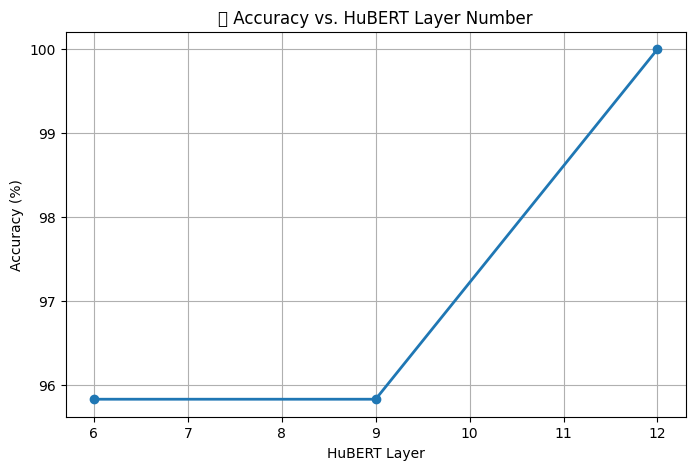

✅ Layer-wise analysis completed and saved!


<Figure size 640x480 with 0 Axes>

In [ ]:
# ==============================================
#  3️ HuBERT Layer-wise Accent Analysis
# ==============================================

# Goal: Identify which HuBERT layer captures accent cues best
# (i.e., which layer produces embeddings that give highest classification accuracy)

# ----------------------------------------------
#  Import Libraries
# ----------------------------------------------
import torch
import numpy as np
import os
import librosa
from tqdm import tqdm
import matplotlib.pyplot as plt
from transformers import AutoFeatureExtractor, HubertModel
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# ----------------------------------------------
# Setup
# ----------------------------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
print("✅ Using device:", device)

DATA_PATH = "/content/drive/MyDrive/Accent1/Accent-Aware-Cuisine-Recommendation/IndicAccentDB"
SAVE_PATH = "/content/drive/MyDrive/Accent1/Accent-Aware-Cuisine-Recommendation"

states = sorted(os.listdir(DATA_PATH))
print("🎧 Languages Detected:", states)

# ----------------------------------------------
#Load HuBERT model (with all hidden states)
# ----------------------------------------------
extractor = AutoFeatureExtractor.from_pretrained("facebook/hubert-base-ls960")
hubert = HubertModel.from_pretrained("facebook/hubert-base-ls960", output_hidden_states=True).to(device)
hubert.eval()

# ----------------------------------------------
# 🎵 Extract embeddings layer-wise
# ----------------------------------------------
LAYER_IDS = [6, 9, 12]  # you can test more layers if needed
features_by_layer = {layer: [] for layer in LAYER_IDS}
labels = []

for label, state in enumerate(states):
    folder = os.path.join(DATA_PATH, state)
    wav_files = [f for f in os.listdir(folder) if f.endswith(".wav")]

    for file in tqdm(wav_files[:20], desc=f"Extracting {state}"):  # smaller subset for speed
        try:
            wav_path = os.path.join(folder, file)
            wav, sr = librosa.load(wav_path, sr=16000)
            inputs = extractor(wav, sampling_rate=16000, return_tensors="pt", padding=True).to(device)

            with torch.no_grad():
                outputs = hubert(**inputs)
                hidden_states = outputs.hidden_states  # list of layer outputs

            # Extract mean embedding for each target layer
            for layer in LAYER_IDS:
                emb = hidden_states[layer].mean(dim=1).squeeze().cpu().numpy()
                features_by_layer[layer].append(emb)

            labels.append(label)

        except Exception as e:
            print(f"⚠️ Error {file}: {e}")
            continue

labels = np.array(labels)

# ----------------------------------------------
# Convert layer features to numpy arrays
# ----------------------------------------------
for layer in LAYER_IDS:
    features_by_layer[layer] = np.array(features_by_layer[layer])
    np.save(f"{SAVE_PATH}/hubert_layer_{layer}_features.npy", features_by_layer[layer])

np.save(f"{SAVE_PATH}/hubert_layer_labels.npy", labels)

print("✅ Saved layer-wise features and labels!")

# ----------------------------------------------
#  Train & Evaluate per layer
# ----------------------------------------------
layer_accuracies = {}

for layer in LAYER_IDS:
    print(f"\n🔹 Evaluating Layer {layer}...")
    X = features_by_layer[layer]
    y = labels

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    model = LogisticRegression(max_iter=2000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred) * 100
    layer_accuracies[layer] = acc

    print(f"✅ Layer {layer} Accuracy: {acc:.2f}%")

# ----------------------------------------------
# 📊 Plot results
# ----------------------------------------------
plt.figure(figsize=(8, 5))
plt.plot(list(layer_accuracies.keys()), list(layer_accuracies.values()), marker='o', linewidth=2)
plt.title("📊 Accuracy vs. HuBERT Layer Number")
plt.xlabel("HuBERT Layer")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.show()

plt.savefig(f"{SAVE_PATH}/hubert_layerwise_accuracy.png", dpi=300, bbox_inches='tight')


# ----------------------------------------------
# 💾 Save results
# ----------------------------------------------
np.save(f"{SAVE_PATH}/hubert_layerwise_accuracies.npy", layer_accuracies)
print("✅ Layer-wise analysis completed and saved!")
